# Tutorial 7 - Inversion of GRACE data

Following on from tutorial 6, we demonstrate a similar application of the pyslfp library, this time for the problem of estimating the surface load from GRACE data.

In [14]:
# Import necessary libraries. 
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import pygeoinf as inf
from pygeoinf.symmetric_space.sphere import Sobolev
import pyslfp as sl
from pyslfp.operators import SeaLevelOperator, GraceObservationOperator, TideGaugeObservationOperator

# Set up the FingerPrint instance
fingerprint = sl.FingerPrint(
    lmax=32,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fingerprint.set_state_from_ice_ng()

In the ```pyslfp``` library, there are a number of standard operators available, implemented as instances of the LinearOperator class in ```pygeoinf```. Here we will use ```SeaLevelOperator```, which is an implementation of the solution to the generalised sea level problem, and ```GraceObservationOperator``` which maps from the four response fields outputted by ```SeaLevelOperator``` to a vector of gravational potential coefficients.

As before, we also require a data error measure.

In [15]:
# Set the parameters for the model space and the data space, as well as parameters for the sea level operator.
order = 2
scale = 0.1
observation_degree = 10
rotational_feedbacks = True
rtol = 1e-6

# Create the sea level operator, which computes the response to a given load.
sea_level_operator = SeaLevelOperator(
    order,
    scale,
    fingerprint=fingerprint,
    rotational_feedbacks=rotational_feedbacks,
    rtol=rtol,
)

# Create the observation operator, which maps the sea level response to the data space.
observation_operator = GraceObservationOperator(
    sea_level_operator, 
    observation_degree
)

# Set the data error measure for the forward ptoblem.
data_space = observation_operator.codomain
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, 0.01)

# Set up the forward problem.
forward_operator = observation_operator.forward_operator
forward_problem = inf.LinearForwardProblem(
    forward_operator,
    data_error_measure
)

# Set a prior distribution.
model_space = sea_level_operator.domain
model_prior_measure = model_space.sobolev_gaussian_measure(2, 0.05, 1)

We can now proceed with the same sort of calculations as in tutorial 6.

global mean sea level change = 0.27072482600044667
estimated global mean sea level change = 0.05805337505802516


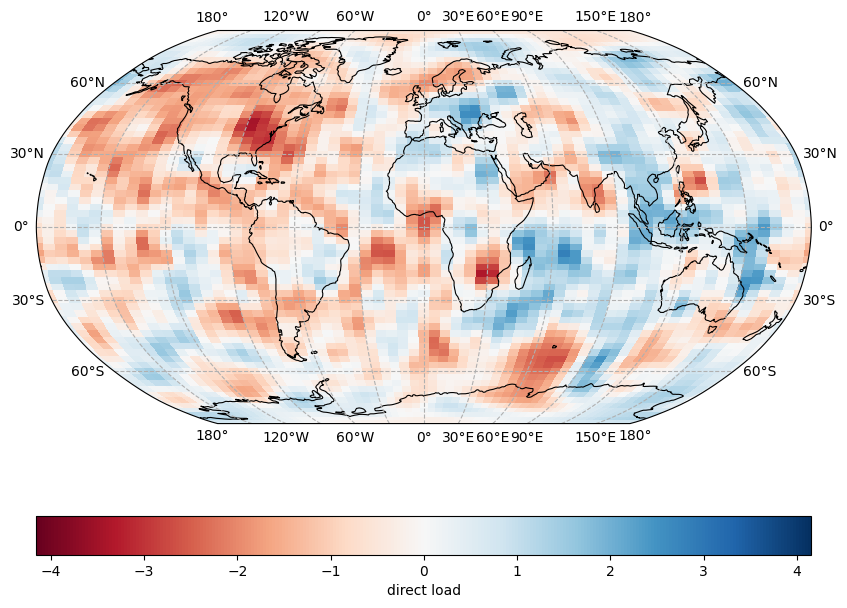

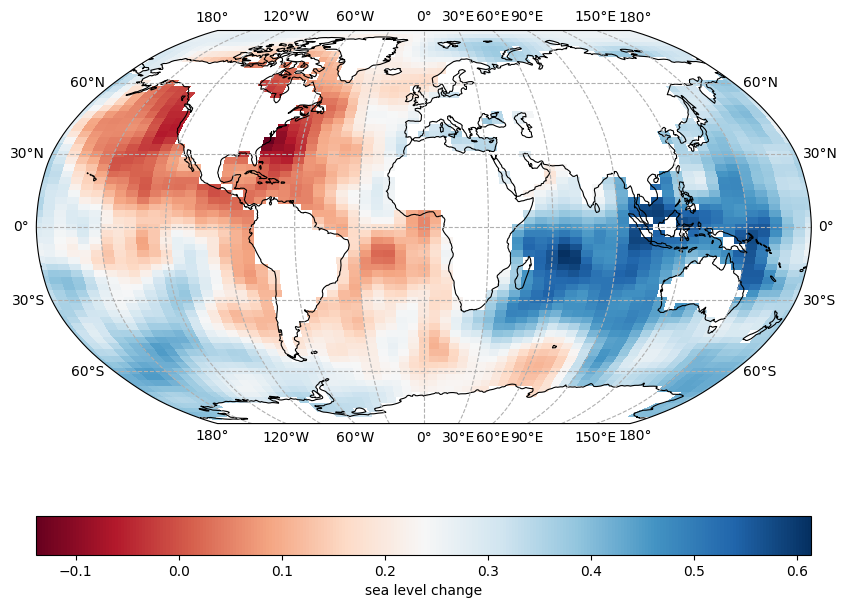

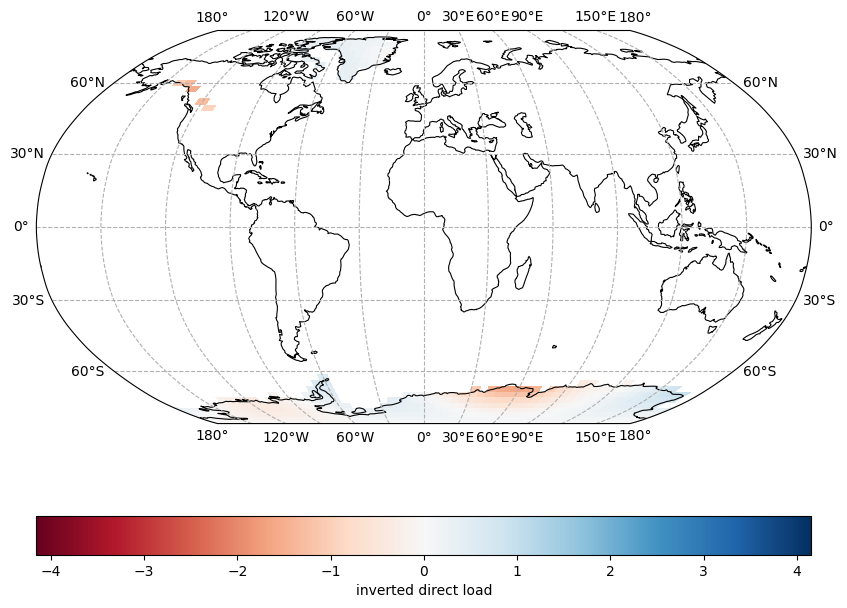

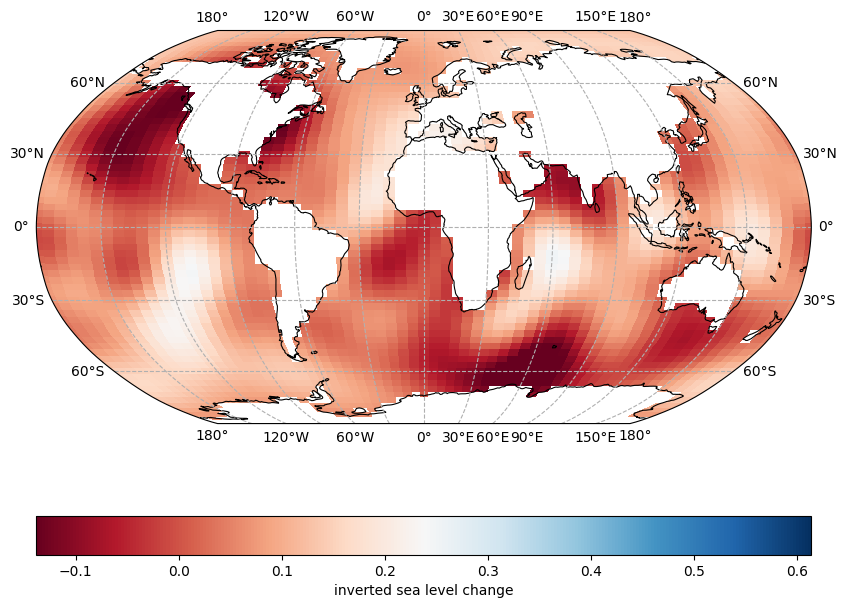

In [17]:
# Set up the inversion
inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Generate synthetic data.
model, data = forward_problem.synthetic_model_and_data(model_prior_measure)
sea_level_change = sea_level_operator(model)[0]

# Plot the direct load input.
fig, ax, im = sl.plot(model, symmetric=True)
model_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="direct load")

# Plot the resulting sea level
fig, ax, im = sl.plot(sea_level_change * fingerprint.ocean_projection())
sea_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="sea level change")

# Invert the data.
pi = inversion.model_posterior_measure(data, inf.CGMatrixSolver())
inverted_model = pi.expectation
inverted_sea_level_change = sea_level_operator(inverted_model)[0]

# Plot the inverted direct load input.
fig, ax, im = sl.plot(inverted_model * fingerprint.ice_projection())
im.set_clim(model_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted direct load")

# Plot the resulting sea level
fig, ax, im = sl.plot(inverted_sea_level_change * fingerprint.ocean_projection())
im.set_clim(sea_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted sea level change")

print(f"global mean sea level change = {fingerprint.ocean_average(sea_level_change)}")
print(
    f"estimated global mean sea level change = {fingerprint.ocean_average(inverted_sea_level_change)}"
)
